In [381]:
# import package
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from sklearn.model_selection import train_test_split
from pcntoolkit.normative import estimate, evaluate
from pcntoolkit.util.utils import create_bspline_basis, compute_MSLL


## Prepare covariate data

In [382]:
wdir = '/home/jovyan/Code/PCNtoolkit-demo'
os.chdir(os.path.join(wdir, 'tutorials/BLR_protocol'))

In [383]:
hcp = pd.read_csv(os.path.join(wdir,'data','HCP1200_age_gender.csv'))
ixi = pd.read_csv(os.path.join(wdir,'data','IXI_age_gender.csv'))

In [384]:
cov = pd.merge(hcp, ixi, on=["participant_id", "age", "sex", "site"], how='outer')

/tmp/ipykernel_52964/4009627928.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  cov = pd.merge(hcp, ixi, on=["participant_id", "age", "sex", "site"], how='outer')


In [385]:
sns.set(font_scale=1.5, style='darkgrid')

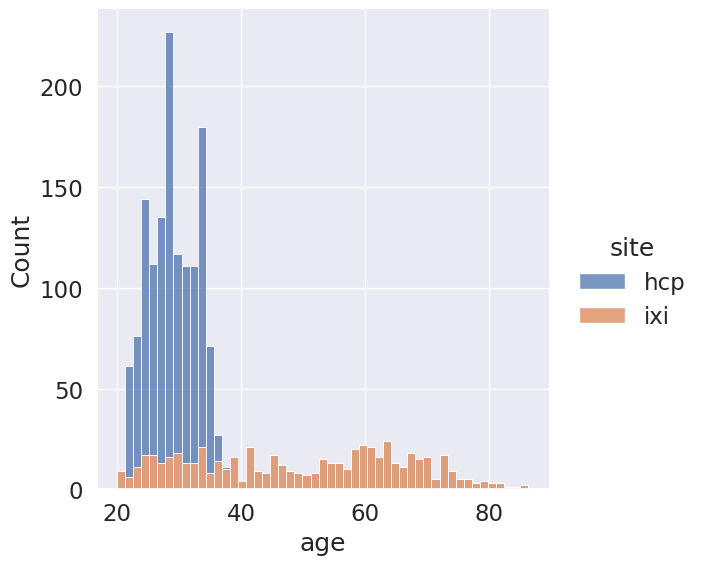

In [386]:
sns.displot(cov, x="age", hue="site", multiple="stack", height=6);

In [387]:
cov.groupby(['site']).describe()

age                                                                                sex                                             
       count       mean        std        min        25%       50%        75%       max   count      mean       std  min  25%  50%  75%  max
site                                                                                                                                        
hcp   1206.0  28.837479   3.690534  22.000000  26.000000  29.00000  32.000000  37.00000  1206.0  1.543947  0.498272  1.0  1.0  2.0  2.0  2.0
ixi    590.0  49.476531  16.720864  19.980835  34.027721  50.61191  63.413415  86.31896   590.0  1.555932  0.497283  1.0  1.0  2.0  2.0  2.0

## Preprare brain data

In [388]:
hcpya = pd.read_csv(os.path.join(wdir,'data','HCP1200_aparc_thickness.csv'))
ixi = pd.read_csv(os.path.join(wdir,'data','IXI_aparc_thickness.csv'))

In [389]:
brain_all = pd.merge(ixi, hcpya, how='outer')

euler number

In [390]:
hcp_euler = pd.read_csv(os.path.join(wdir,'data','hcp-ya_euler.csv'))
ixi_euler = pd.read_csv(os.path.join(wdir,'data','ixi_euler.csv'))

In [391]:
hcp_euler['site'] = 'hcp'
ixi_euler['site'] = 'ixi'

In [392]:
hcp_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)
ixi_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [393]:
hcp_euler.dropna(inplace=True)
ixi_euler.dropna(inplace=True)

In [394]:
hcp_euler['rh_euler'] = hcp_euler['rh_euler'].astype(int)
hcp_euler['lh_euler'] = hcp_euler['lh_euler'].astype(int)
ixi_euler['rh_euler'] = ixi_euler['rh_euler'].astype(int)
ixi_euler['lh_euler'] = ixi_euler['lh_euler'].astype(int)

In [395]:
df_euler = pd.merge(hcp_euler, ixi_euler, on=['participant_id', 'lh_euler', 'rh_euler', 'site'], how='outer')

Finally, we need to center the euler number for each site.The euler number is very site-specific so in order to use the same exclusion threshold across sites we need to center the site by subtracting the site median from all subjects at a site.  

In [396]:
df_euler['avg_euler'] = df_euler[['lh_euler','rh_euler']].mean(axis=1)

In [397]:
df_euler.groupby(by='site')['avg_euler'].median()

site
hcp   -43.0
ixi   -56.0
Name: avg_euler, dtype: float64

In [398]:
df_euler['site_median'] = df_euler['site']

In [399]:
df_euler['site_median'] = df_euler['site_median'].replace({'hcp':-43,'ixi':-56})

/tmp/ipykernel_52964/2211394117.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_euler['site_median'] = df_euler['site_median'].replace({'hcp':-43,'ixi':-56})


In [400]:
df_euler['avg_euler_centered'] = df_euler['avg_euler'] - df_euler['site_median']

In [401]:
df_euler['avg_euler_centered_neg'] = df_euler['avg_euler_centered']*-1

In [402]:
df_euler['avg_euler_centered_neg_sqrt'] = np.sqrt(np.absolute(df_euler['avg_euler_centered_neg']))

In [403]:
brain = pd.merge(df_euler, brain_all, on=['participant_id'], how='inner')

In [404]:
brain_good = brain.query('avg_euler_centered_neg_sqrt < 10')

## Combine covariate & cortical thickness dataframes

In [405]:
# make sure to use how="inner" so that we only include subjects that have data in both the covariate and the cortical thickness files 
all_data = pd.merge(brain_good, cov, how='inner')

In [406]:
# Create a list of all the ROIs you want to run a normative model for (add additional names to this list if you would like to include other brain regions from the Desikan-Killian atlas)
roi_ids = ['lh_MeanThickness_thickness',
           'rh_MeanThickness_thickness',
           'lh_bankssts_thickness',
           'lh_caudalanteriorcingulate_thickness',
           'lh_superiorfrontal_thickness',
           'rh_superiorfrontal_thickness']

In [407]:
# Remove any subjects that have NaN variables in any of the columns
all_data.dropna(subset=roi_ids, inplace=True)

In [408]:
all_data_features = all_data[roi_ids]

In [409]:
all_data_covariates = all_data[['age','sex','site']]

## Add variable to model site/scanner effects

Currently, the different sites are coded in a single column (named ‘site’) and are represented as a string data type. However, the PCNtoolkit requires binary variables. Use the pandas package as follows to address this, which has a built-in function, `pd.get_dummies`, that takes in the string ‘site’ column and dummy encodes the site variable so that there is now a column for each site and the columns contain binary variables (0=not in this site, 1=present in this site).

In [410]:
all_data_covariates = pd.get_dummies(all_data_covariates, columns=['site'])

In [411]:
site_dummy_cols = [col for col in all_data_covariates.columns if col.startswith('site_')]
all_data_covariates[site_dummy_cols] = all_data_covariates[site_dummy_cols].astype(int)

In [412]:
print(all_data_covariates)

            age  sex  site_hcp  site_ixi
0     27.000000    1         1         0
1     27.000000    2         1         0
2     33.000000    1         1         0
3     27.000000    1         1         0
4     35.000000    2         1         0
...         ...  ...       ...       ...
1687  47.723477    1         0         1
1688  50.395619    1         0         1
1689  42.989733    1         0         1
1690  46.220397    1         0         1
1691  41.741273    1         0         1

[1692 rows x 4 columns]


## Train/test split

In [415]:
X_train, X_test, y_train, y_test = train_test_split(all_data_covariates, all_data_features, stratify=all_data['site'], test_size=0.2, random_state=42)

In [416]:
tr_cov_size = X_train.shape
tr_resp_size = y_train.shape
te_cov_size = X_test.shape
te_resp_size = y_test.shape
print("Train covariate size is: ", tr_cov_size)
print("Test covariate size is: ", te_cov_size)
print("Train response size is: ", tr_resp_size)
print("Test response size is: ", te_resp_size)

Train covariate size is:  (1353, 4)
Test covariate size is:  (339, 4)
Train response size is:  (1353, 6)
Test response size is:  (339, 6)


In [417]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [418]:
# Get indices of all the subejcts in each site so that we can evaluate the test set metrics per site
hcp_idx = X_test.index[X_test['site_hcp'] == 1].to_list()
ixi_idx = X_test.index[X_test['site_ixi'] == 1].to_list()

In [419]:
# Save the site indices into a single list
sites = [hcp_idx, ixi_idx]

In [420]:
# Create a list with sites names to use in evaluating per-site metrics
site_names = ['hcp', 'ixi']

## Setup output directories

In [421]:
for c in y_train.columns:
    y_train[c].to_csv('resp_tr_' + c + '.txt', header=False, index=False)

In [422]:
X_train.to_csv('cov_tr.txt', sep = '\t', header=False, index = False)

In [423]:
y_train.to_csv('resp_tr.txt', sep = '\t', header=False, index = False)

In [424]:
for c in y_test.columns:
    y_test[c].to_csv('resp_te_' + c + '.txt', header=False, index=False)

In [425]:
X_test.to_csv('cov_te.txt', sep = '\t', header=False, index = False)

In [426]:
y_test.to_csv('resp_te.txt', sep = '\t', header=False, index = False)

In [427]:
! if [[ ! -e ROI_models/ ]]; then mkdir ROI_models; fi

In [428]:
# Note: please change the path in the following to wdir (depending on whether you are running on colab or not)

! for i in `cat /home/jovyan/Code/PCNtoolkit-demo/data/roi_dir_names`; do if [[ -e resp_tr_${i}.txt ]]; then cd ROI_models; mkdir ${i}; cd ../; cp resp_tr_${i}.txt ROI_models/${i}/resp_tr.txt; cp resp_te_${i}.txt ROI_models/${i}/resp_te.txt; cp cov_tr.txt ROI_models/${i}/cov_tr.txt; cp cov_te.txt ROI_models/${i}/cov_te.txt; fi; done

In [429]:
# clean up files
! rm resp_*.txt 

In [430]:
# clean up files
! rm cov_t*.txt

# Algorithm & Modeling

## Basis expansion using B-Splines

In [373]:
# set this path to wherever your ROI_models folder is located (where you copied all of the covariate & response text files to in Step 4)
data_dir = os.path.join(wdir, "tutorials", "BLR_protocol", "ROI_models")

# Create a cubic B-spline basis (used for regression)
xmin = 10#16 # xmin & xmax are the boundaries for ages of participants in the dataset
xmax = 95#90
B = create_bspline_basis(xmin, xmax)
# create the basis expansion for the covariates for each of the 
for roi in roi_ids: 
    print('Creating basis expansion for ROI:', roi)
    roi_dir = os.path.join(data_dir, roi)
    os.chdir(roi_dir)
    # create output dir 
    os.makedirs(os.path.join(roi_dir,'blr'), exist_ok=True)
    # load train & test covariate data matrices
    X_tr = np.loadtxt(os.path.join(roi_dir, 'cov_tr.txt'))
    X_te = np.loadtxt(os.path.join(roi_dir, 'cov_te.txt'))
    # add intercept column 
    X_tr = np.concatenate((X_tr, np.ones((X_tr.shape[0],1))), axis=1)
    X_te = np.concatenate((X_te, np.ones((X_te.shape[0],1))), axis=1)
    np.savetxt(os.path.join(roi_dir, 'cov_int_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_int_te.txt'), X_te)
    
    # create Bspline basis set 
    Phi = np.array([B(i) for i in X_tr[:,0]])
    Phis = np.array([B(i) for i in X_te[:,0]])
    X_tr = np.concatenate((X_tr, Phi), axis=1)
    X_te = np.concatenate((X_te, Phis), axis=1)
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_te.txt'), X_te)

Creating basis expansion for ROI: lh_MeanThickness_thickness
Creating basis expansion for ROI: rh_MeanThickness_thickness
Creating basis expansion for ROI: lh_bankssts_thickness
Creating basis expansion for ROI: lh_caudalanteriorcingulate_thickness
Creating basis expansion for ROI: lh_superiorfrontal_thickness
Creating basis expansion for ROI: rh_superiorfrontal_thickness


## Estimate normative model

Set up a variable (`data_dir`) that specifies the path to the ROI directories that were created in Step 7. Initiate two empty pandas data frames where the evaluation metrics are the column names, as follows; one will be used for overall test set evaluation (`blr_metrics`) and one will be used for site-specific test set evaluation (`blr_site_metrics`). After the normative model has been estimated, these data frames will be saved as individual csv files.

In [374]:
# Create pandas dataframes with header names to save out the overall and per-site model evaluation metrics
blr_metrics = pd.DataFrame(columns = ['ROI', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])
blr_site_metrics = pd.DataFrame(columns = ['ROI', 'site', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])

Estimate the normative models using a for loop to iterate over brain regions. An important consideration is whether to re-scale or standardize the covariates or responses. Whilst this generally only has a minor effect on the final model accuracy, it has implications for the interpretation of models and how they are configured. If the covariates and responses are both standardized (`standardize = True`), the model will return standardized coefficients. If (as in this case) the response variables are not standardized (`standardized = False`), then the scaling both covariates and responses will be reflected in the estimated coefficients. Also, under the linear modeling approach employed here, if the coefficients are unstandardized and do not have a zero mean, it is necessary to add an intercept column to the design matrix (this is done above in step 9 (B-spline)). The estimate function uses a few specific arguments that are worthy of commenting on: 

    - alg = 'blr': specifies we should use Bayesian Linear Regression.  
    - optimizer = 'powell': use Powell's derivative-free optimization method (faster in this case than L-BFGS) 
    - savemodel = False: do not write out the final estimated model to disk 
    - saveoutput = False: return the outputs directly rather than writing them to disk
    - standardize = False: Do not standardize the covariates or response variables

In [376]:
# Loop through ROIs
for roi in roi_ids: 
    print('Running ROI:', roi)
    roi_dir = os.path.join(data_dir, roi)
    os.chdir(roi_dir)
     
    # configure the covariates to use. Change *_bspline_* to *_int_* to 
    cov_file_tr = os.path.join(roi_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(roi_dir, 'cov_bspline_te.txt')
    
    # load train & test response files
    resp_file_tr = os.path.join(roi_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(roi_dir, 'resp_te.txt') 
    
    # run a basic model
    yhat_te, s2_te, nm, Z, metrics_te = estimate(cov_file_tr, 
                                                 resp_file_tr, 
                                                 testresp=resp_file_te, 
                                                 testcov=cov_file_te, 
                                                 alg = 'blr', 
                                                 optimizer = 'powell', 
                                                 savemodel = True, 
                                                 saveoutput = False,
                                                 standardize = False,
                                                 binary = False)
    # save metrics
    blr_metrics.loc[len(blr_metrics)] = [roi, metrics_te['MSLL'][0], metrics_te['EXPV'][0], metrics_te['SMSE'][0], metrics_te['RMSE'][0], metrics_te['Rho'][0]]
    
    # Compute metrics per site in test set, save to pandas df
    # load true test data
    X_te = np.loadtxt(cov_file_te)
    y_te = np.loadtxt(resp_file_te)
    y_te = y_te[:, np.newaxis] # make sure it is a 2-d array
    
    # load training data (required to compute the MSLL)
    y_tr = np.loadtxt(resp_file_tr)
    y_tr = y_tr[:, np.newaxis]
    
    for num, site in enumerate(sites):     
        y_mean_te_site = np.array([[np.mean(y_te[site])]])
        y_var_te_site = np.array([[np.var(y_te[site])]])
        yhat_mean_te_site = np.array([[np.mean(yhat_te[site])]])
        yhat_var_te_site = np.array([[np.var(yhat_te[site])]])
        
        metrics_te_site = evaluate(y_te[site], yhat_te[site], s2_te[site], y_mean_te_site, y_var_te_site)
        
        site_name = site_names[num]
        blr_site_metrics.loc[len(blr_site_metrics)] = [roi, site_names[num], metrics_te_site['MSLL'][0], metrics_te_site['EXPV'][0], metrics_te_site['SMSE'][0], metrics_te_site['RMSE'][0], metrics_te_site['Rho'][0]]

Running ROI: lh_MeanThickness_thickness
Processing data in /home/jovyan/Code/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/lh_MeanThickness_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/home/jovyan/conda-environments/normativemodel/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=2.03455e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1162.792820
         Iterations: 2
         Function evaluations: 43
Saving model meta-data...
Evaluating the model ...
Running ROI: rh_MeanThickness_thickness
Processing data in /home/jovyan/Code/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/rh_MeanThickness_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/home/jovyan/conda-environments/normativemodel/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:196: LinAlgWarning: Ill-conditioned matrix (rcond=7.68964e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -1187.621858
         Iterations: 2
         Function evaluations: 43
Saving model meta-data...
Evaluating the model ...
Running ROI: lh_bankssts_thickness
Processing data in /home/jovyan/Code/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/lh_bankssts_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -578.945257
         Iterations: 2
         Function evaluations: 42
Saving model meta-data...
Evaluating the model ...
Running ROI: lh_caudalanteriorcingulate_thickness
Processing data in /home/jovyan/Code/PCNtoolkit-demo/tutorials/BLR_protocol/ROI_models/lh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -235.509099
         Iterations: 3
   

# Evaluation & Interpretation

## Describe the normative model performance

In [377]:
# Overall test set evaluation metrics
print(blr_metrics['EV'].describe())
print(blr_metrics['MSLL'].describe())
print(blr_metrics['SMSE'].describe())
print(blr_metrics['Rho'].describe())

count    12.000000
mean      0.216747
std       0.109049
min       0.063284
25%       0.160170
50%       0.204015
75%       0.271766
max       0.397232
Name: EV, dtype: float64
count    12.000000
mean     -0.131996
std       0.076295
min      -0.267055
25%      -0.161529
50%      -0.120775
75%      -0.087402
max      -0.034441
Name: MSLL, dtype: float64
count    12.000000
mean      0.784798
std       0.109342
min       0.603410
25%       0.729136
50%       0.798426
75%       0.842463
max       0.936928
Name: SMSE, dtype: float64
count    12.000000
mean      0.452088
std       0.120937
min       0.257838
25%       0.401801
50%       0.450319
75%       0.521317
max       0.630935
Name: Rho, dtype: float64


## Visualize normative model outputs

### Figure 4A viz

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2432x1824 with 0 Axes>

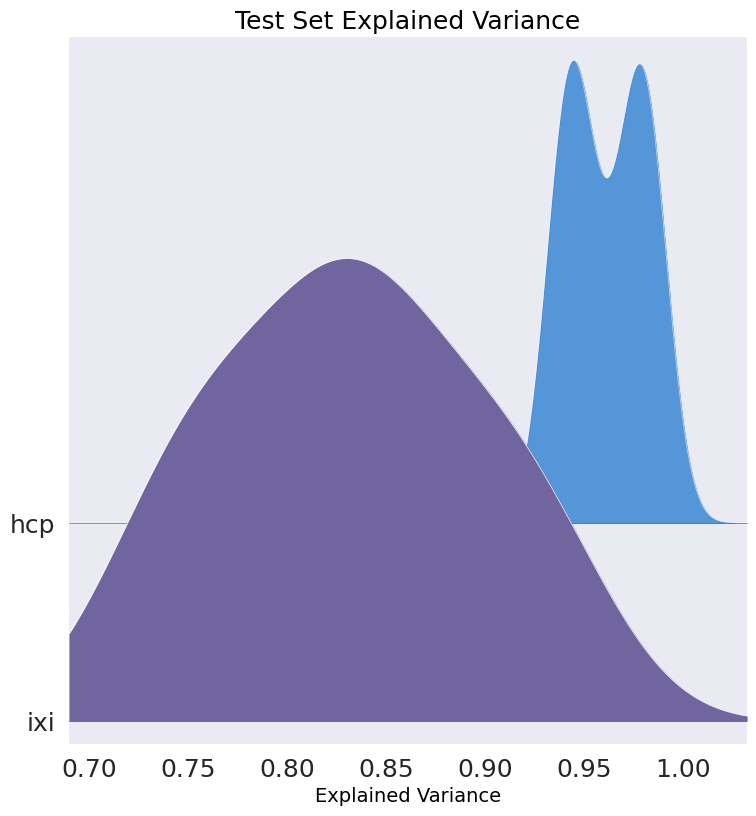

In [380]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return r, g, b

plt.figure(dpi=380)
fig, axes = joypy.joyplot(blr_site_metrics, column=['SMSE'], overlap=2.5, by="site", ylim='own', fill=True, figsize=(8,8)
                          , legend=False, xlabels=True, ylabels=True, colormap=lambda x: color_gradient(x, start=(.08, .45, .8),stop=(.8, .34, .44))
                          , alpha=0.6, linewidth=.5, linecolor='w', fade=True);
plt.title('Test Set Explained Variance', fontsize=18, color='black', alpha=1)
plt.xlabel('Explained Variance', fontsize=14, color='black', alpha=1)
plt.ylabel('Site', fontsize=14, color='black', alpha=1)
plt.show